# Test de modelisation pour prédire la Consommation

Nous allons essayer de tester des modèles de regression afin de prédire la consommation : 
- La regression simple
- La regression multiple

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_validate

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression



FILE_PATH_METEO = 'data_meteo_prod.csv'

In [2]:
df_meteo = pd.read_csv(FILE_PATH_METEO, sep=',')
df_meteo['date'] =  pd.to_datetime(df_meteo['date'])
df_meteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30671 entries, 0 to 30670
Data columns (total 26 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   region                                      30671 non-null  object        
 1   rafales_sur_une_periode                     30671 non-null  float64       
 2   variation_de_pression_en_3_heures           30671 non-null  float64       
 3   precipitations_dans_les_3_dernieres_heures  30671 non-null  float64       
 4   regioncode                                  30671 non-null  float64       
 5   pression_station                            30671 non-null  float64       
 6   pression_au_niveau_mer                      30671 non-null  float64       
 7   direction_du_vent_moyen                     30671 non-null  float64       
 8   vitesse_du_vent_moyen                       30671 non-null  float64       
 9   humidi

**En nous basant sur la heatmap, nous supprimons des features quelques variables inutiles pour notre test ou des variables pouvant biaiser le test**

In [3]:
features = df_meteo.drop(['consommation_mw', 'latitude', 'prod_totale', 'longitude', 'altitude', 'regioncode', 'region',
                        'thermique_mw', 'eolien_mw', 'solaire_mw', 'nucleaire_mw', 'pompage_mw', 'ech._physiques_mw', 'hydraulique_mw',
                         ], axis=1)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30671 entries, 0 to 30670
Data columns (total 12 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   rafales_sur_une_periode                     30671 non-null  float64       
 1   variation_de_pression_en_3_heures           30671 non-null  float64       
 2   precipitations_dans_les_3_dernieres_heures  30671 non-null  float64       
 3   pression_station                            30671 non-null  float64       
 4   pression_au_niveau_mer                      30671 non-null  float64       
 5   direction_du_vent_moyen                     30671 non-null  float64       
 6   vitesse_du_vent_moyen                       30671 non-null  float64       
 7   humidite                                    30671 non-null  float64       
 8   point_de_rosee                              30671 non-null  float64       
 9   temper

**Définition de la target pour notre recherche :**

In [4]:
features_simple = df_meteo[['bioenergies_mw']]
target = df_meteo[['consommation_mw','date']]
target2 = df_meteo['consommation_mw']

**Vérification linéarité entre conso et bioenergies**

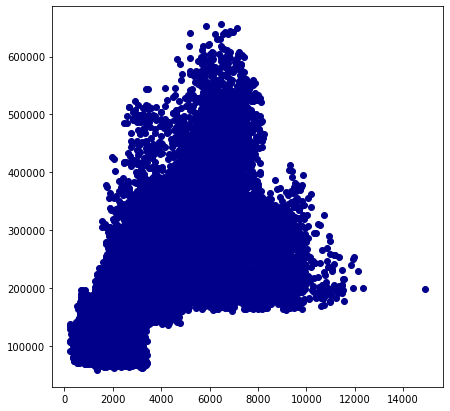

In [5]:
plt.figure(figsize=(7,7))

plt.scatter(df_meteo['bioenergies_mw'], df_meteo['consommation_mw'], color='darkblue')

In [6]:
slr = LinearRegression()
slr.fit(features_simple, target2)
print(slr.intercept_)
print(slr.coef_)

99470.85247252959
[30.68831938]


Ici le modèle peut se modélise de cette façon :  consommation =99470+30.688∗bioenergie

In [7]:
cross_validate(slr, features_simple, target2, return_train_score=True, cv=4)
cross_validate(slr, features_simple, target2, return_train_score=True, cv=4)['test_score'].mean()

0.3779312520014018

Le modèle linéaire simple n'est pas performant avec l'utilisation de la variable la plus corrélé. La production du bioenergie n'explique que 37.7% de la variance de la conso.

### Essayons un modèle de regression multiple :

In [8]:
#Séparation des dataframes en test et train : 
features['year'] = features['date'].dt.year
target['year'] = target['date'].dt.year

X_train = features[features['year'] != 2019].drop(['year', 'date'], axis = 1) 
X_test = features[features['year'] == 2019].drop(['year', 'date'], axis = 1) 
y_train = target[target['year'] != 2019].drop(['year', 'date'], axis = 1) 
y_test = target[target['year'] == 2019].drop(['year', 'date'], axis = 1) 

#instanciation du modèle : 
lr = LinearRegression()

#entrainement du modèle : 
lr.fit(X_train, y_train)

#Affichage du R2 et du R2 par Crossvalidation
print('Coefficient de détermination du modèle :', lr.score(X_train, y_train))
print('Coefficient de détermination obtenu par Cv :', cross_val_score(lr,X_train,y_train).mean())

Coefficient de détermination du modèle : 0.5879295131726485
Coefficient de détermination obtenu par Cv : 0.5682028310195036


<ipython-input-8-650f7188cb7d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['year'] = target['date'].dt.year


Le modèle n'est efficace qu'à 56%. Il convient de tester d'autre modèle, notamment le modèle sarima en utilisant les données temporelles pour essayer d'obtenir une meilleur visibilité de la consommation. Par ailleurs, nous avons conserver la production de bioenergie pour prédire la conso, ce qui biaise notre analyse. Sans la bioenergie, donc que la météo, nous obtenons un score de 0.20. Ce qui est très faible. 